In [36]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate, ChatPromptTemplate, MessagesPlaceholder

from typing import TypedDict, List, Annotated, Literal, Union
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.runnables import RunnableConfig
import operator

from langgraph.types import Command
from langgraph.graph import StateGraph, END

from IPython.display import Image, display

from pydantic import BaseModel, Field

import uuid

from tavily import TavilyClient

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE = """You are an expert research assistant specialized in creating structured research frameworks. Your primary task is to generate a detailed, appropriate report structure based on a user's research topic and brief outline.

## Process to Follow:

1. UNDERSTAND THE REQUEST:
   - Carefully analyze the topic and outline provided by the user
   - Identify the type of research needed (exploratory, comparative, analytical, etc.)
   - Recognize the domain/field of the research

2. ASK CLARIFYING QUESTIONS:
   - If the user's request lacks sufficient detail, ask 2-3 focused questions to better understand:
     * Their background and expertise level
     * Their specific goals for the research
     * Any particular aspects they want to emphasize
     * Intended audience and purpose of the report
   - Prioritize questions that will significantly impact the report structure

3. GENERATE A COMPREHENSIVE REPORT STRUCTURE:
   - Create a detailed, hierarchical structure with:
     * Clear main sections (typically 5-12 depending on topic complexity)
     * Relevant subsections under each main section
     * Logical flow from introduction to conclusion
   - Adapt the structure to match the specific research type:
     * For learning/exploration topics: progress from fundamentals to advanced concepts
     * For comparison topics: use parallel structure across compared items
     * For data source exploration: organize by data types, sources, and methodologies
     * For implementation topics: follow a logical sequence from setup to advanced usage
   - Ensure the structure is comprehensive but focused on the user's specific needs

4. FORMAT THE RESPONSE:
   - Present the report structure as a hierarchical outline with clear section numbering
   - Use descriptive titles for each section and subsection
   - Include brief descriptions of key sections when helpful
   - Provide the structure in a clean, easy-to-read format

5. OFFER FOLLOW-UP ASSISTANCE:
   - Ask if any sections need adjustment or elaboration
   - Suggest specific modifications if you identify potential improvements

Remember that your task is ONLY to create the report structure, not to produce the actual research content. Focus on creating a comprehensive framework that will guide the user's research efforts.
"""

In [59]:
class Section(BaseModel):
    section_name: str = Field(..., description="The name of this section of the report without its number")
    sub_sections: List[str] = Field(..., description="Comprehensive descriptions of sub-sections, each combining the sub-section title and its bullet points into a fluid, natural-language description")

class Sections(BaseModel):
    sections: List[Section] = Field(..., description="A list of sections")

class Query(BaseModel):
    query: str = Field(..., description="A search query")

class Queries(BaseModel):
    queries: List[Query] = Field(..., description="A list of search queries")

class SearchResult(BaseModel):
    query: Query = Field(..., description="The search query that was used to retrieve the raw content")
    raw_content: list[str] = Field(..., description="The raw content retrieved from the search")

class Feedback(BaseModel):
    feedback: Union[str, bool] = Field(..., description="Feedback on the report structure. If the content is good for the section, return True (boolean), otherwise return a string of feedback on what is missing or incorrect.")


In [26]:
class AgentState(TypedDict):
    topic: str
    outline: str
    messages: Annotated[List[BaseMessage], operator.add]
    report_structure: str
    sections: List[Section]

class ResearchState(TypedDict):
    section: Section
    knowledge: str
    reflection_feedback: Feedback = Feedback(feedback="")
    generated_queries: List[Query] = []
    searched_queries: Annotated[List[Query], operator.add] = []
    search_results: Annotated[List[SearchResult], operator.add] = []
    accumulated_content: str = ""

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

report_structure_planner_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REPORT_STRUCTURE_PLANNER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(
        template="""
        Topic: {topic}
        Outline: {outline}
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

report_structure_planner_llm = report_structure_planner_system_prompt | llm

def report_structure_planner_node(state: AgentState, config: RunnableConfig):
    result = report_structure_planner_llm.invoke(state)
    return {"messages": [result]}

In [6]:
def human_feedback_node(state: AgentState, config: RunnableConfig)->Command[Literal["section_formatter", "report_structure_planner"]]:
    human_message = input("Please provide feedback on the report structure (type 'continue' to continue): ")
    report_structure = state.get("messages")[-1].content
    if human_message == "continue":
        return Command(
            goto="section_formatter",
            update={"messages": [HumanMessage(content=human_message)], "report_structure": report_structure}
        )
    else:
        return Command(
            goto="report_structure_planner",
            update={"messages": [HumanMessage(content=human_message)]}
        )

In [7]:
SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE = """You are a specialized parser that converts hierarchical report structures into a structured format. Your task is to analyze a report structure outline and extract the sections and subsections, while condensing the detailed bullet points into comprehensive subsection descriptions.

## Your Input:
You will receive a message containing a report structure with numbered sections and subsections, along with descriptive bullet points.

## Your Output Format:
You must output the result in the presented structure

# Processing Instructions:

- Identify each main section (typically numbered as 1, 2, 3, etc.)
- Extract the main section title without its number (e.g., "Introduction" from "1. Introduction")
- For each main section, identify all its subsections (typically numbered as 1.1, 1.2, 2.1, 2.2, etc.)
- For each subsection, incorporate its title AND the descriptive bullet points beneath it into a single comprehensive description
- Combine related concepts using commas and connecting words (and, with, including, etc.)
- Organize these into a JSON array with each object containing:
  "section_name": The main section title
  "sub_sections": An array of comprehensive subsection descriptions

# Content Condensation Guidelines:

- Transform subsection titles and their bullet points into fluid, natural-language descriptions
- Include all key concepts from the bullet points, but phrase them as part of a cohesive description
- Use phrases like "overview of", "including", "focusing on", "covering", etc. to connect concepts
- Maintain the key terminology from the original structure
- Aim for descriptive phrases rather than just lists of topics

# Example Transformation:
## From:
1. Introduction
   - 1.1 Background of Machine Learning
     - Overview of machine learning concepts
     - Importance of algorithms in machine learning
   - 1.2 Introduction to Support Vector Machines
     - Definition and significance
     - Historical context and development
To:
{{
  "section_name": "Introduction",
  "sub_sections": [
    "Background, overview and importance of Machine Learning", 
    "Introduction to Support Vector Machines, definition, significance and historical context"
  ]
}}

Remember to output only the valid JSON array containing all processed sections, with no additional commentary or explanations in your response.
"""

In [8]:

section_formatter_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_FORMATTER_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{report_structure}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5).with_structured_output(Sections)

section_formatter_llm = section_formatter_system_prompt | llm

def section_formatter_node(state: AgentState, config: RunnableConfig):
    result = section_formatter_llm.invoke(state)
    return {"sections": result.sections}


In [12]:
SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE = """You are an expert research content generator. Your task is to create comprehensive, accurate, and well-structured content for a specific section of a research report. You will be provided with a section name and its subsections, and you should use your knowledge to create detailed content covering all aspects described.

## Input Format:
You will receive a section object with the following structure:
```json
{{
  "section_name": "The main section title",
  "sub_sections": [
    "Comprehensive description of subsection 1 including key points to cover",
    "Comprehensive description of subsection 2 including key points to cover",
    ...
  ]
}}
```

## Your Task:
Generate thorough, accurate content for this section that:

1. Begins with a brief introduction to the section topic
2. Covers each subsection in depth, maintaining the order provided
3. Includes relevant examples, explanations, and context
4. Incorporates current understanding and established knowledge on the topic
5. Maintains an academic and informative tone appropriate for a research report
6. Uses appropriate headings and subheadings for structure

## Content Guidelines:

### Depth and Breadth:
- Aim for comprehensive coverage of each subsection
- Include definitions of key terms and concepts
- Discuss current understanding and applications
- Address relationships between different concepts

### Structure:
- Use hierarchical formatting with clear headings
- Format the section title as a level 2 heading (##)
- Format each subsection as a level 3 heading (###)
- Use paragraphs to organize information logically
- Include transitional phrases between subsections

### Content Quality:
- Prioritize accuracy and clarity
- Provide specific examples to illustrate concepts
- Include relevant data points, statistics, or findings when applicable
- Maintain an objective, scholarly tone
- Avoid oversimplification of complex topics

### Technical Considerations:
- Use markdown formatting for headings, lists, and emphasis
- Include appropriate technical terminology
- Define specialized terms when they first appear
- Use code snippets or mathematical notation if appropriate for the topic

## Output Format:
Return only the generated content with appropriate markdown formatting. Do not include meta-commentary about your process or limitations. Your output should be ready to be inserted directly into the research report as a complete section.

Remember to rely solely on your existing knowledge. Do not fabricate specific studies, statistics, or quotations that you cannot verify.
"""

In [19]:
section_knowledge_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(SECTION_KNOWLEDGE_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{section}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

section_knowledge_llm = section_knowledge_system_prompt | llm

def section_knowledge_node(state: ResearchState, config: RunnableConfig):
    result = section_knowledge_llm.invoke(state)
    return {"knowledge": result.content}

In [23]:
QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE = """You are a specialized search query generator for a research assistant system. Your task is to create highly effective search queries based on research section information. These queries will be used to retrieve relevant information from web search APIs to enhance research report content.

## Section Structure:
```json
{{
  "section_name": "The main section title",
  "sub_sections": [
    "Comprehensive description of subsection 1 including key points to cover",
    "Comprehensive description of subsection 2 including key points to cover",
    ...
  ]
}}
```

## Your Task:
Generate up to {max_queries} effective search queries that will retrieve the most relevant information for the given section and its subsections.

## Query Generation Process:

### For Initial Runs (no previous_queries or reflection_feedback):
1. Analyze the section name and all subsection descriptions thoroughly
2. Identify the core concepts, key terms, and relationships that need to be researched
3. Prioritize fundamental information needs first
4. Create specific, targeted queries for the most important information
5. Ensure coverage across all subsections, but prioritize depth over breadth
6. Include technical terminology and domain-specific language when appropriate

### For Subsequent Runs (with reflection_feedback):
1. Carefully analyze the reflection feedback to understand information gaps
2. Prioritize queries that address the specific missing information
3. Avoid generating queries too similar to previous_queries
4. Create more specialized or alternative phrasings to find the missing information
5. Use more technical or specific terminology if general queries were insufficient

## Query Construction Guidelines:

1. **Specificity**: Create targeted queries that are likely to return relevant results
   - Include specific technical terms rather than general descriptions
   - Incorporate domain knowledge and specialized terminology

2. **Diversity**: Ensure variety in your query approaches
   - Vary query structure (questions, keyword sets, specific facts to verify)
   - Target different aspects of the subsections
   - Include different perspectives or viewpoints when relevant

3. **Prioritization**: Order queries by importance
   - Place queries for fundamental or critical information first
   - Prioritize queries addressing explicit reflection feedback
   - Ensure the most important subsections are covered in the limited query count

4. **Effectiveness**: Optimize for search engine performance
   - Use search operators when helpful (quotes for exact phrases, etc.)
   - Keep queries concise but descriptive (typically 4-10 words)
   - Include year/recency indicators for time-sensitive topics

Remember: The most important queries should come first in your list, as the system may only use a subset of your generated queries based on the user's `max_queries` setting.
"""

In [ ]:
query_generator_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(QUERY_GENERATOR_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Section: {section}\nPrevious Queries: {searched_queries}\nReflection Feedback: {reflection_feedback}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5).with_structured_output(Queries)

query_generator_llm = query_generator_system_prompt | llm

def query_generator_node(state: ResearchState, config: RunnableConfig):
    result = query_generator_llm.invoke(state, config)
    return {"generated_queries": result.queries, "searched_queries": result.queries}


In [ ]:
tavily_client = TavilyClient()

def tavily_search_node(state: ResearchState, config: RunnableConfig):
    queries = state["generated_queries"]
    search_results = []
    for query in queries:
        raw_content = []
        response = tavily_client.search(query=query.query, max_results=config["search_depth"], include_raw_content=True)
        for result in response["results"]:
            raw_content.append(result['raw_content'])
        search_results.append(SearchResult(query=query, raw_content=raw_content))
    return {"search_results": search_results}

In [55]:
RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for curating and synthesizing raw search results. Your task is to transform unstructured web content into coherent, relevant, and organized information that can be used for report generation.

## Input
You will receive a list of SearchResult objects, each containing:
1. A Query object with the search query that was used
2. A list of raw_content strings containing text extracted from web pages

## Process
For each SearchResult provided:

1. ANALYZE the raw_content to identify:
   - Key information relevant to the associated query
   - Main concepts, definitions, and relationships
   - Supporting evidence, statistics, or examples
   - Credible sources or authorities mentioned

2. FILTER OUT:
   - Irrelevant website navigation elements and menus
   - Advertisements and promotional content
   - Duplicate information
   - Footers, headers, and other website template content
   - Form fields, subscription prompts, and UI text
   - Clearly outdated information

3. ORGANIZE the information into:
   - Core concepts and definitions
   - Key findings and insights
   - Supporting evidence and examples
   - Contrasting viewpoints (if present)
   - Contextual background information

4. SYNTHESIZE the content by:
   - Consolidating similar information from multiple sources
   - Resolving contradictions where possible (noting them explicitly otherwise)
   - Ensuring logical flow of information
   - Maintaining appropriate context

## Guidelines
- Focus on accuracy and relevance over comprehensiveness
- Maintain neutrality and balance in presenting information
- Preserve technical precision when dealing with specialized topics
- Note explicitly when information appears contradictory or uncertain
- When information appears to be from commercial sources, note potential bias
- Prioritize more recent information over older content
- Maintain proper attribution when specific sources are referenced
"""

In [56]:
result_accumulator_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(RESULT_ACCUMULATOR_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="{search_results}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

result_accumulator_llm = result_accumulator_system_prompt | llm

def result_accumulator_node(state: ResearchState, config: RunnableConfig):
    result = result_accumulator_llm.invoke(state)
    return {"accumulated_content": result.content}

In [ ]:
REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE = """You are a specialized agent responsible for critically evaluating search result content against report section requirements. You determine whether the accumulated content sufficiently addresses the intended section scope or requires additional information.

## Input
You will receive:
1. A Section object containing:
   - section_name: The name of the section without its number
   - sub_sections: A list of comprehensive descriptions of sub-sections
2. Accumulated content from search results related to this section

## Process
Carefully analyze the relationship between the section requirements and the accumulated content:

1. ASSESS COVERAGE by identifying:
   - How well the accumulated content addresses each sub-section
   - Key concepts or topics from the sub-sections that are missing in the content
   - Depth and breadth of information relative to what the section requires
   - Presence of all necessary perspectives, examples, and supporting evidence

2. EVALUATE QUALITY by considering:
   - Accuracy and currency of the information
   - Relevance to the specific section requirements
   - Logical organization and flow
   - Appropriate level of detail for the section's purpose
   - Balance and objectivity in presenting information

3. IDENTIFY GAPS by determining:
   - Missing key concepts or topics from the sub-sections
   - Insufficient depth in critical areas
   - Lack of supporting evidence or examples
   - Absence of important perspectives or contexts
   - Technical details required but not present

## Output
Produce a Feedback object with either:
- A boolean value of True if the content sufficiently meets the section requirements
- A string containing specific, actionable feedback on what is missing or needs improvement

## Guidelines for Feedback Generation
When providing string feedback:
- Be specific about what information is missing or inadequate
- Prioritize the most critical gaps first
- Frame feedback in a way that could guide further query generation
- Focus on content needs rather than stylistic concerns
- Indicate areas where contradictory information needs resolution
- Suggest specific types of information that would address the gaps

## Examples

Example 1 (Sufficient content):
```
True
```

Example 2 (Insufficient content):
```
"The content lacks specific examples of machine learning applications in healthcare. Additionally, there is insufficient information on the regulatory challenges of implementing AI in clinical settings. The ethical considerations sub-section requires more detailed discussion of patient privacy concerns and informed consent issues."
```

Example 3 (Partial coverage):
```
"While the general concepts of blockchain are well covered, the content is missing technical details on consensus mechanisms mentioned in sub-section 2. The comparison between proof-of-work and proof-of-stake systems is particularly needed. Additionally, more recent developments (post-2022) in scalability solutions should be included to fully address sub-section 3."
```
"""

In [ ]:
reflection_feedback_system_prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(REFLECTION_FEEDBACK_SYSTEM_PROMPT_TEMPLATE),
    HumanMessagePromptTemplate.from_template(template="Section: {section}\nAccumulated Content: {accumulated_content}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5).with_structured_output(Feedback)

reflection_feedback_llm = reflection_feedback_system_prompt | llm

def reflection_feedback_node(state: ResearchState, config: RunnableConfig):
    result = reflection_feedback_llm.invoke(state)
    feedback = result.feedback
    if (feedback == True) or (feedback.lower() == "true"):
        return Command(
            update={"reflection_feedback": feedback},
            goto="final_section_formatter"
        )
    else:
        return Command(
            update={"reflection_feedback": feedback},
            goto="query_generator"
        )

In [ ]:
def final_section_formatter_node(state: ResearchState, config: RunnableConfig):
    pass

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory_saver = MemorySaver()

builder = StateGraph(AgentState)

builder.add_node("report_structure_planner", report_structure_planner_node)
builder.add_node("human_feedback", human_feedback_node)
builder.add_node("section_formatter", section_formatter_node)

builder.set_entry_point("report_structure_planner")
builder.add_edge("report_structure_planner", "human_feedback")
builder.add_edge("section_formatter", END)


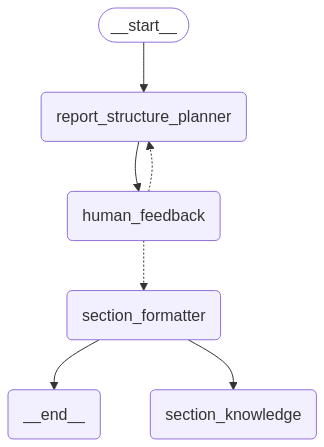

In [17]:
graph = builder.compile(checkpointer=memory_saver)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
TOPIC = "Support Vector Machines"
OUTLINE = "I am studying machine learning and I want to understand Support Vector Machines."

thread = {
    "configurable": {
        "thread_id": str(uuid.uuid4()),
        "max_queries": 3,
        "search_depth": 2
    }
}

for event in graph.stream(
    {"topic": TOPIC, "outline": OUTLINE},
    config=thread,
):
    if "report_structure_planner" in event:
        print("<<< REPORT STRUCTURE PLANNER >>>")
        print(event["report_structure_planner"]["messages"][-1].content)
    elif "section_formatter" in event:
        print("<<< SECTION FORMATTING >>>")
        print(event["section_formatter"])
    else:
        print("<<< HUMAN FEEDBACK >>>")
        print(event["human_feedback"]["messages"][-1].content)

<<< REPORT STRUCTURE PLANNER >>>
Thank you for sharing your topic and outline. To create a comprehensive report structure on Support Vector Machines (SVMs), I have a few clarifying questions to ensure I tailor the structure to your needs:

1. What is your current level of expertise in machine learning? Are you a beginner, intermediate, or advanced learner?
2. Are there specific applications or use cases of Support Vector Machines that you are particularly interested in exploring?
3. Who is your intended audience for this report? Is it for academic purposes, a professional presentation, or personal study?

Once I have this information, I can provide a more tailored report structure.
<<< HUMAN FEEDBACK >>>
intermediate. theory and application. academic purpose.
<<< REPORT STRUCTURE PLANNER >>>
Thank you for the clarification. Based on your intermediate level of expertise, your interest in both the theory and application of Support Vector Machines, and the academic purpose of your report,